# <center> <b>Well Production Forecasting Using Machine Learning </b></center>

## <b>Data Preparation</b>

In [3]:
# Importing relevant libraries

# Data preprocessing, cleaning and visualization
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, date 
import matplotlib.pyplot as plt
%matplotlib inline

# Model Selection and evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats

# Model Training
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pickle
import warnings
warnings.filterwarnings('ignore')

In [85]:
# Reading train and validation data
train_data = pd.read_csv("C:/Users/IKECHUKWU_OKWUOSA/Documents/ML Datasets/SPE ESDAT Africa/dseats_2024_training_dataset.csv")
train = train_data.copy()
test_data = pd.read_csv( "C:/Users/IKECHUKWU_OKWUOSA/Documents/ML Datasets/SPE ESDAT Africa/dseats_2024_validation_dataset.csv")
test = test_data.copy()

In [87]:
# Setting "PRODUCTION DATE" as index
train["PRODUCTION DATE"] = pd.to_datetime(train["PRODUCTION DATE"],format='mixed')
test["PRODUCTION DATE"] = pd.to_datetime(test["PRODUCTION DATE"],format='mixed')
train.set_index("PRODUCTION DATE", inplace=True)
test.set_index("PRODUCTION DATE", inplace=True)

In [89]:
features =[c for c in train.columns if c not in ["PRODUCTION DATE","Oil Production (stb/day)", 'Gas Volume (scf/day)','Water Production (stb/day)']]
test = test.iloc[:2075]
train = train.sort_values(by="PRODUCTION DATE")
target_oil = train["Oil Production (stb/day)"]
target_gas = train['Gas Volume (scf/day)']
target_water = train["Water Production (stb/day)"]

In [91]:
print("Train size:", train.shape)
print("Test size:", test.shape)
print("Target shape:", target_gas.shape, target_oil.shape, target_water.shape)

Train size: (6925, 15)
Test size: (2075, 15)
Target shape: (6925,) (6925,) (6925,)


In [93]:
# Checking null values (There are 6 null values in the "choke size" column)
display(train.isnull().sum())
# Fill null values with the median
train["Choke Size"] = train["Choke Size"].fillna(train["Choke Size"].median())

Field Name                       0
WELL_BORE_CODE                   0
N_WELL_BORE_CODE                 0
WellBore Name                    0
FLOW_KIND                        0
WELL_TYPE                        0
Downhole Pressure (PSI)          0
Downhole Temperature (Kelvin)    0
Average Tubing Pressure          0
Annulus Pressure (PSI)           0
AVG WHP (PSI)                    0
Choke Size                       6
Oil Production (stb/day)         0
Gas Volume (scf/day)             0
Water Production (stb/day)       0
dtype: int64

## <b> Exploratory Data Analysis</b>

In [131]:
train

,Field Name,WELL_BORE_CODE,N_WELL_BORE_CODE,WellBore Name,FLOW_KIND,WELL_TYPE,Downhole Pressure (PSI),Downhole Temperature (Kelvin),Average Tubing Pressure,Annulus Pressure (PSI),AVG WHP (PSI),Choke Size,Oil Production (stb/day),Gas Volume (scf/day),Water Production (stb/day)
PRODUCTION DATE,,,,,,,,,,,,,,,
2008-01-03,DSEAT,DSEAT-001-F-12 H,107,001-F-12,production,OP,4159.928094,379.059089,2581.939053,161.755131,1577.989041,75.573165,19300.7392,1.579972e+07,2.8934
2008-01-03,DSEAT,DSEAT-001-F-14 H,108,001-F-14,production,OP,0.000000,273.150000,0.000000,0.010005,0.000000,7.275100,0.0000,0.000000e+00,0.0000
2008-01-04,DSEAT,DSEAT-001-F-12 H,107,001-F-12,production,OP,3920.214475,379.039148,2507.459404,166.307097,1412.755070,66.386227,19251.1740,1.616165e+07,17.7378
2008-01-04,DSEAT,DSEAT-001-F-14 H,108,001-F-14,production,OP,0.000000,273.150000,0.000000,0.000000,0.000000,30.421270,0.0000,0.000000e+00,0.0000
2008-01-05,DSEAT,DSEAT-001-F-14 H,108,001-F-14,production,OP,0.000000,273.150000,0.000000,0.000000,0.000000,18.244340,0.0000,0.000000e+00,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-06,DSEAT,DSEAT-001-F-1 C,105,001-F-1 C,production,OP,3769.841687,381.094950,3284.975236,0.000000,484.866452,5.694804,1338.8265,1.096232e+06,8097.5573
2015-12-06,DSEAT,DSEAT-001-F-15 D,109,001-F-15 D,production,OP,2900.965011,379.422346,2452.984213,193.032377,447.980799,2.266941,772.0975,6.321888e+05,57.2390
2015-12-06,DSEAT,DSEAT-001-F-14 H,108,001-F-14,production,OP,3853.658055,372.643576,3413.720234,211.582589,439.937821,1.815075,1295.2997,1.060602e+06,19980.6882


In [132]:
# Checking date range for train and test data
print(f"Train DateIndex Range: {min(train.index)} to {max(train.index)}")
print(f"Test DateIndex Range: {min(test.index)} to {max(test.index)}")

Train DateIndex Range: 2008-01-03 00:00:00 to 2015-12-06 00:00:00
Test DateIndex Range: 2015-07-01 00:00:00 to 2016-09-17 00:00:00


In [15]:
train["WELL_BORE_CODE"].value_counts()# Feature has 5 unique values

WELL_BORE_CODE
DSEAT-001-F-12 H    2611
DSEAT-001-F-14 H    2611
DSEAT-001-F-11 H     720
DSEAT-001-F-15 D     533
DSEAT-001-F-1 C      450
Name: count, dtype: int64

In [16]:
train["N_WELL_BORE_CODE"].value_counts()# Feature has 5 unique values

N_WELL_BORE_CODE
107    2611
108    2611
106     720
109     533
105     450
Name: count, dtype: int64

In [17]:
train["WellBore Name"].value_counts()# Feature has 5 unique values

WellBore Name
001-F-12      2611
001-F-14      2611
001-F-11       720
001-F-15 D     533
001-F-1 C      450
Name: count, dtype: int64

<b><i>The frequency and distribution of unique values in "WELL_BORE_CODE", "N_WELL_BORE_CODE" and "WellBore Name" columns are the same</i></b>

In [19]:
train["Field Name"].value_counts()
# Feature has no 1 unique value. Hence, there are no variations implying feature redundancy.

Field Name
DSEAT    6925
Name: count, dtype: int64

In [20]:
train["FLOW_KIND"].value_counts()
# Feature has no 1 unique value. Hence, there are no variations implying feature redundancy.

FLOW_KIND
production    6925
Name: count, dtype: int64

In [21]:
train["WELL_TYPE"].value_counts()
# Distribution of unique value is highly skewed implying feature redundancy.

WELL_TYPE
OP    6924
WI       1
Name: count, dtype: int64

### <b>Univariate analysis </b>

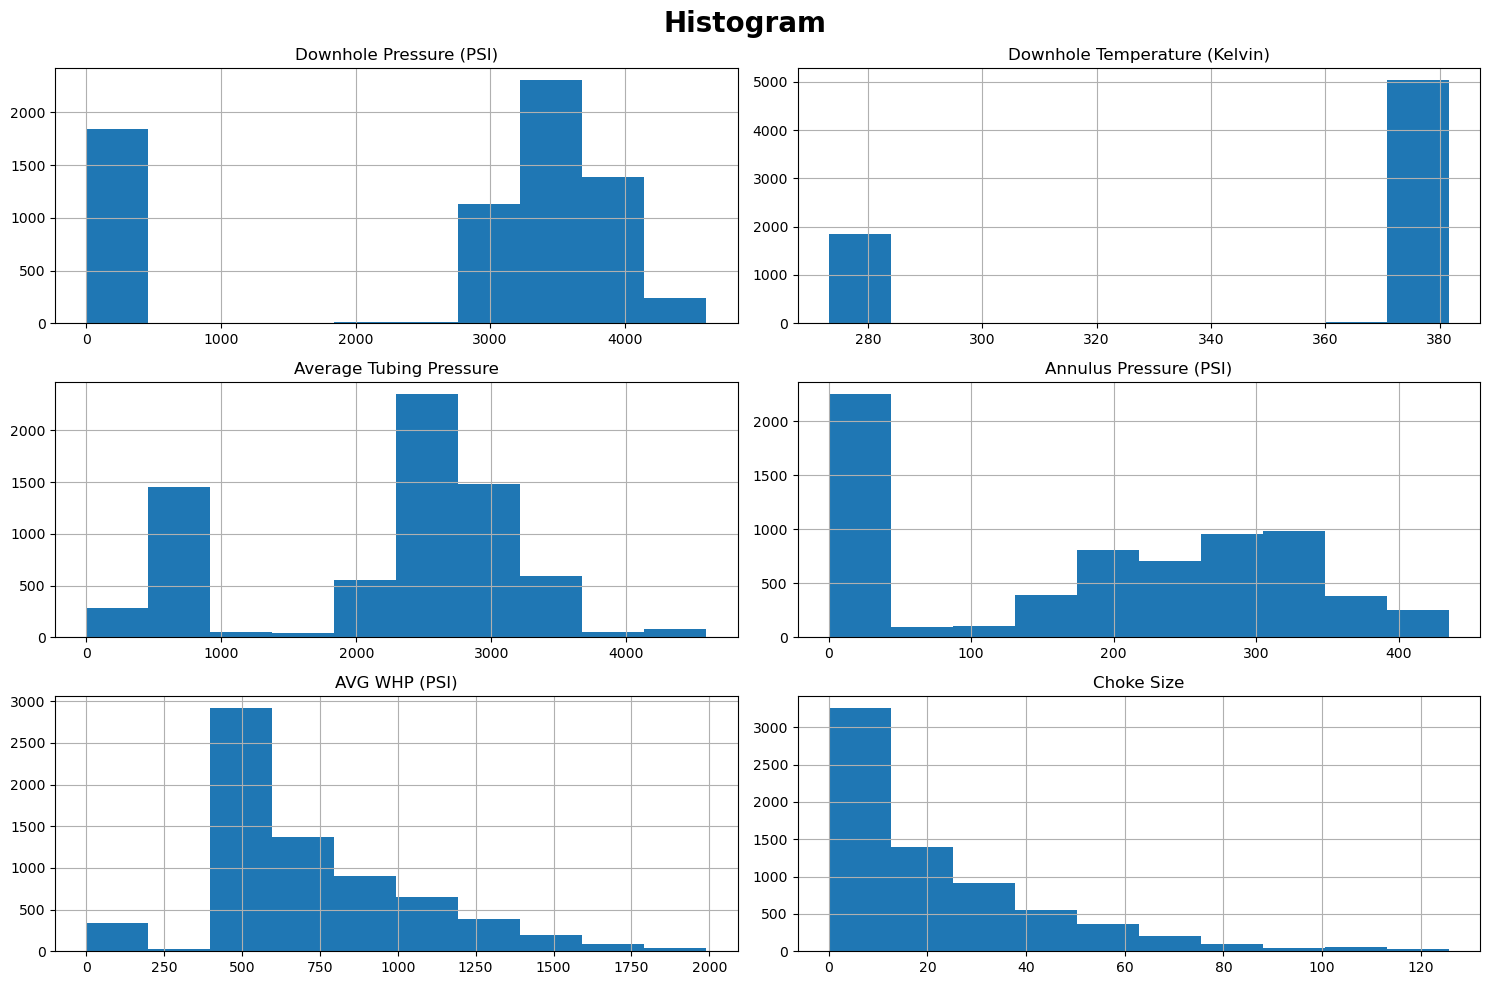

In [23]:
fig,ax = plt.subplots(figsize = (15,10), nrows=2, ncols=1)
train[features].drop(columns=["N_WELL_BORE_CODE"]).hist(ax = ax[0])
plt.suptitle("Histogram", fontsize=20, fontweight="bold")
plt.tight_layout()
plt.show()

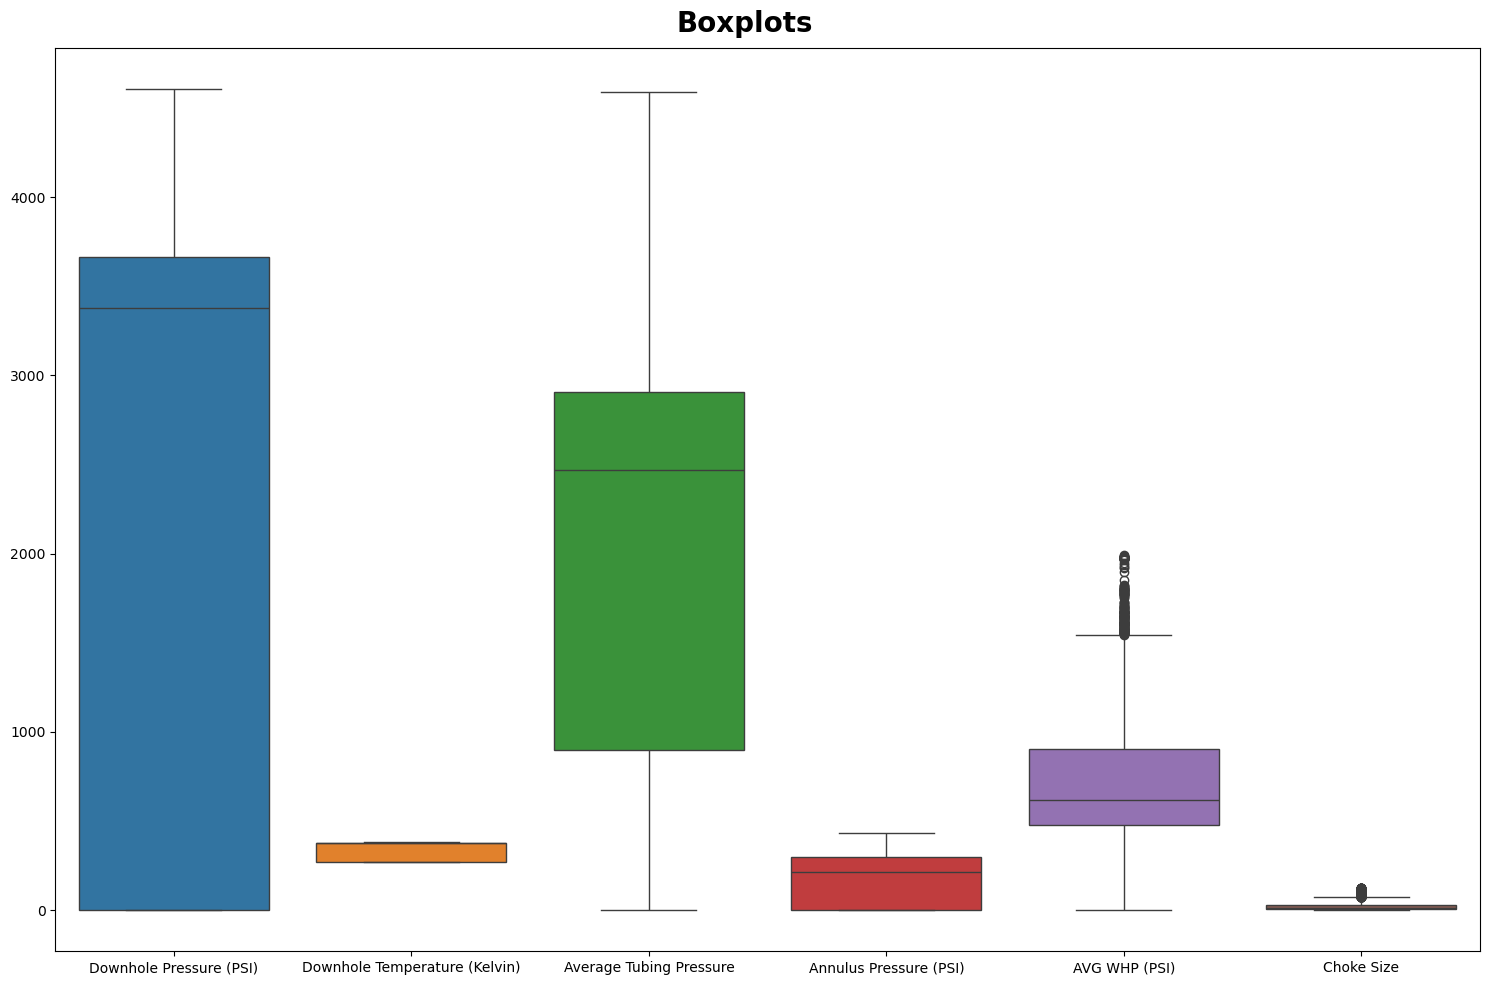

In [24]:
fig,ax = plt.subplots(figsize = (15,10))
sns.boxplot(train[features].drop(columns=["N_WELL_BORE_CODE"]))
plt.suptitle("Boxplots", fontsize=20, fontweight="bold")
plt.tight_layout()
plt.show()

<i><b> - According to the boxplots, "AVG WHP(PSI)" and "Choke Size" features have outliers</b></i><br>
<i><b> - Average Tubing Pressure has the greatest variability</b></i>

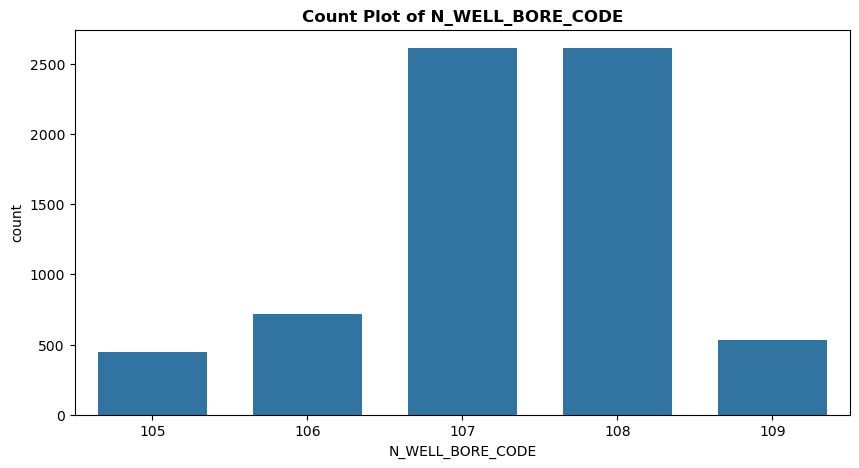

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(data = train, x ="N_WELL_BORE_CODE", width= 0.7)
plt.title("Count Plot of N_WELL_BORE_CODE", fontsize=12, fontweight="bold")
plt.show()

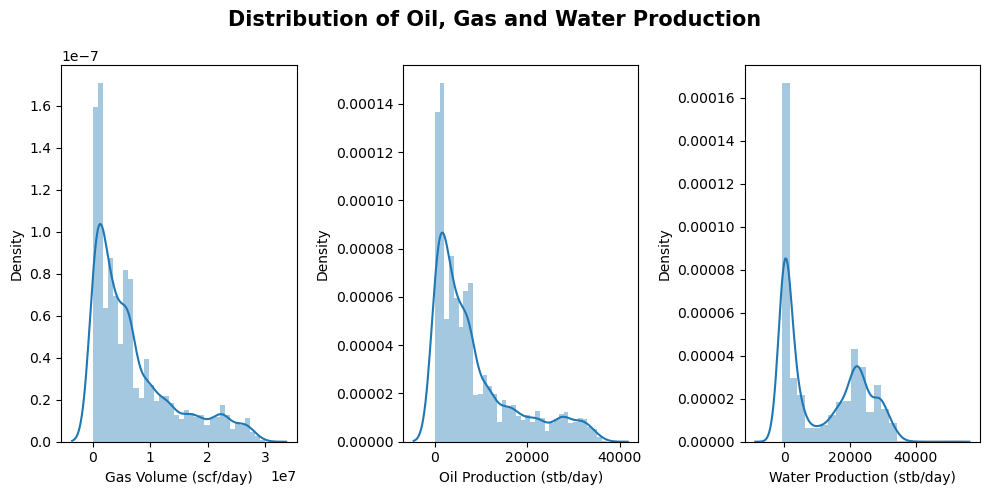

In [27]:
fig, axes = plt.subplots(nrows =1, ncols = 3, figsize=(10, 5))
plt.suptitle("Distribution of Oil, Gas and Water Production",fontsize=15, fontweight="bold" )
sns.distplot(target_gas, ax = axes[0] , kde =True)
sns.distplot(target_oil, ax = axes[1],kde =True )
sns.distplot(target_water, ax = axes[2] , kde =True)
plt.tight_layout()
plt.show()

<i><b> - Gas Volume and Oil Production have similar distributions</b></i>

In [40]:
features =[ 'Downhole Pressure (PSI)',
 'Downhole Temperature (Kelvin)',
 'Average Tubing Pressure',
 'Annulus Pressure (PSI)',
 'AVG WHP (PSI)',
 'Choke Size', 'Oil Production (stb/day)', 'Gas Volume (scf/day)',
       'Water Production (stb/day)']

Index(['Field Name', 'WELL_BORE_CODE', 'N_WELL_BORE_CODE', 'WellBore Name',
       'FLOW_KIND', 'WELL_TYPE', 'Downhole Pressure (PSI)',
       'Downhole Temperature (Kelvin)', 'Average Tubing Pressure',
       'Annulus Pressure (PSI)', 'AVG WHP (PSI)', 'Choke Size',
       'Oil Production (stb/day)', 'Gas Volume (scf/day)',
       'Water Production (stb/day)'],
      dtype='object')

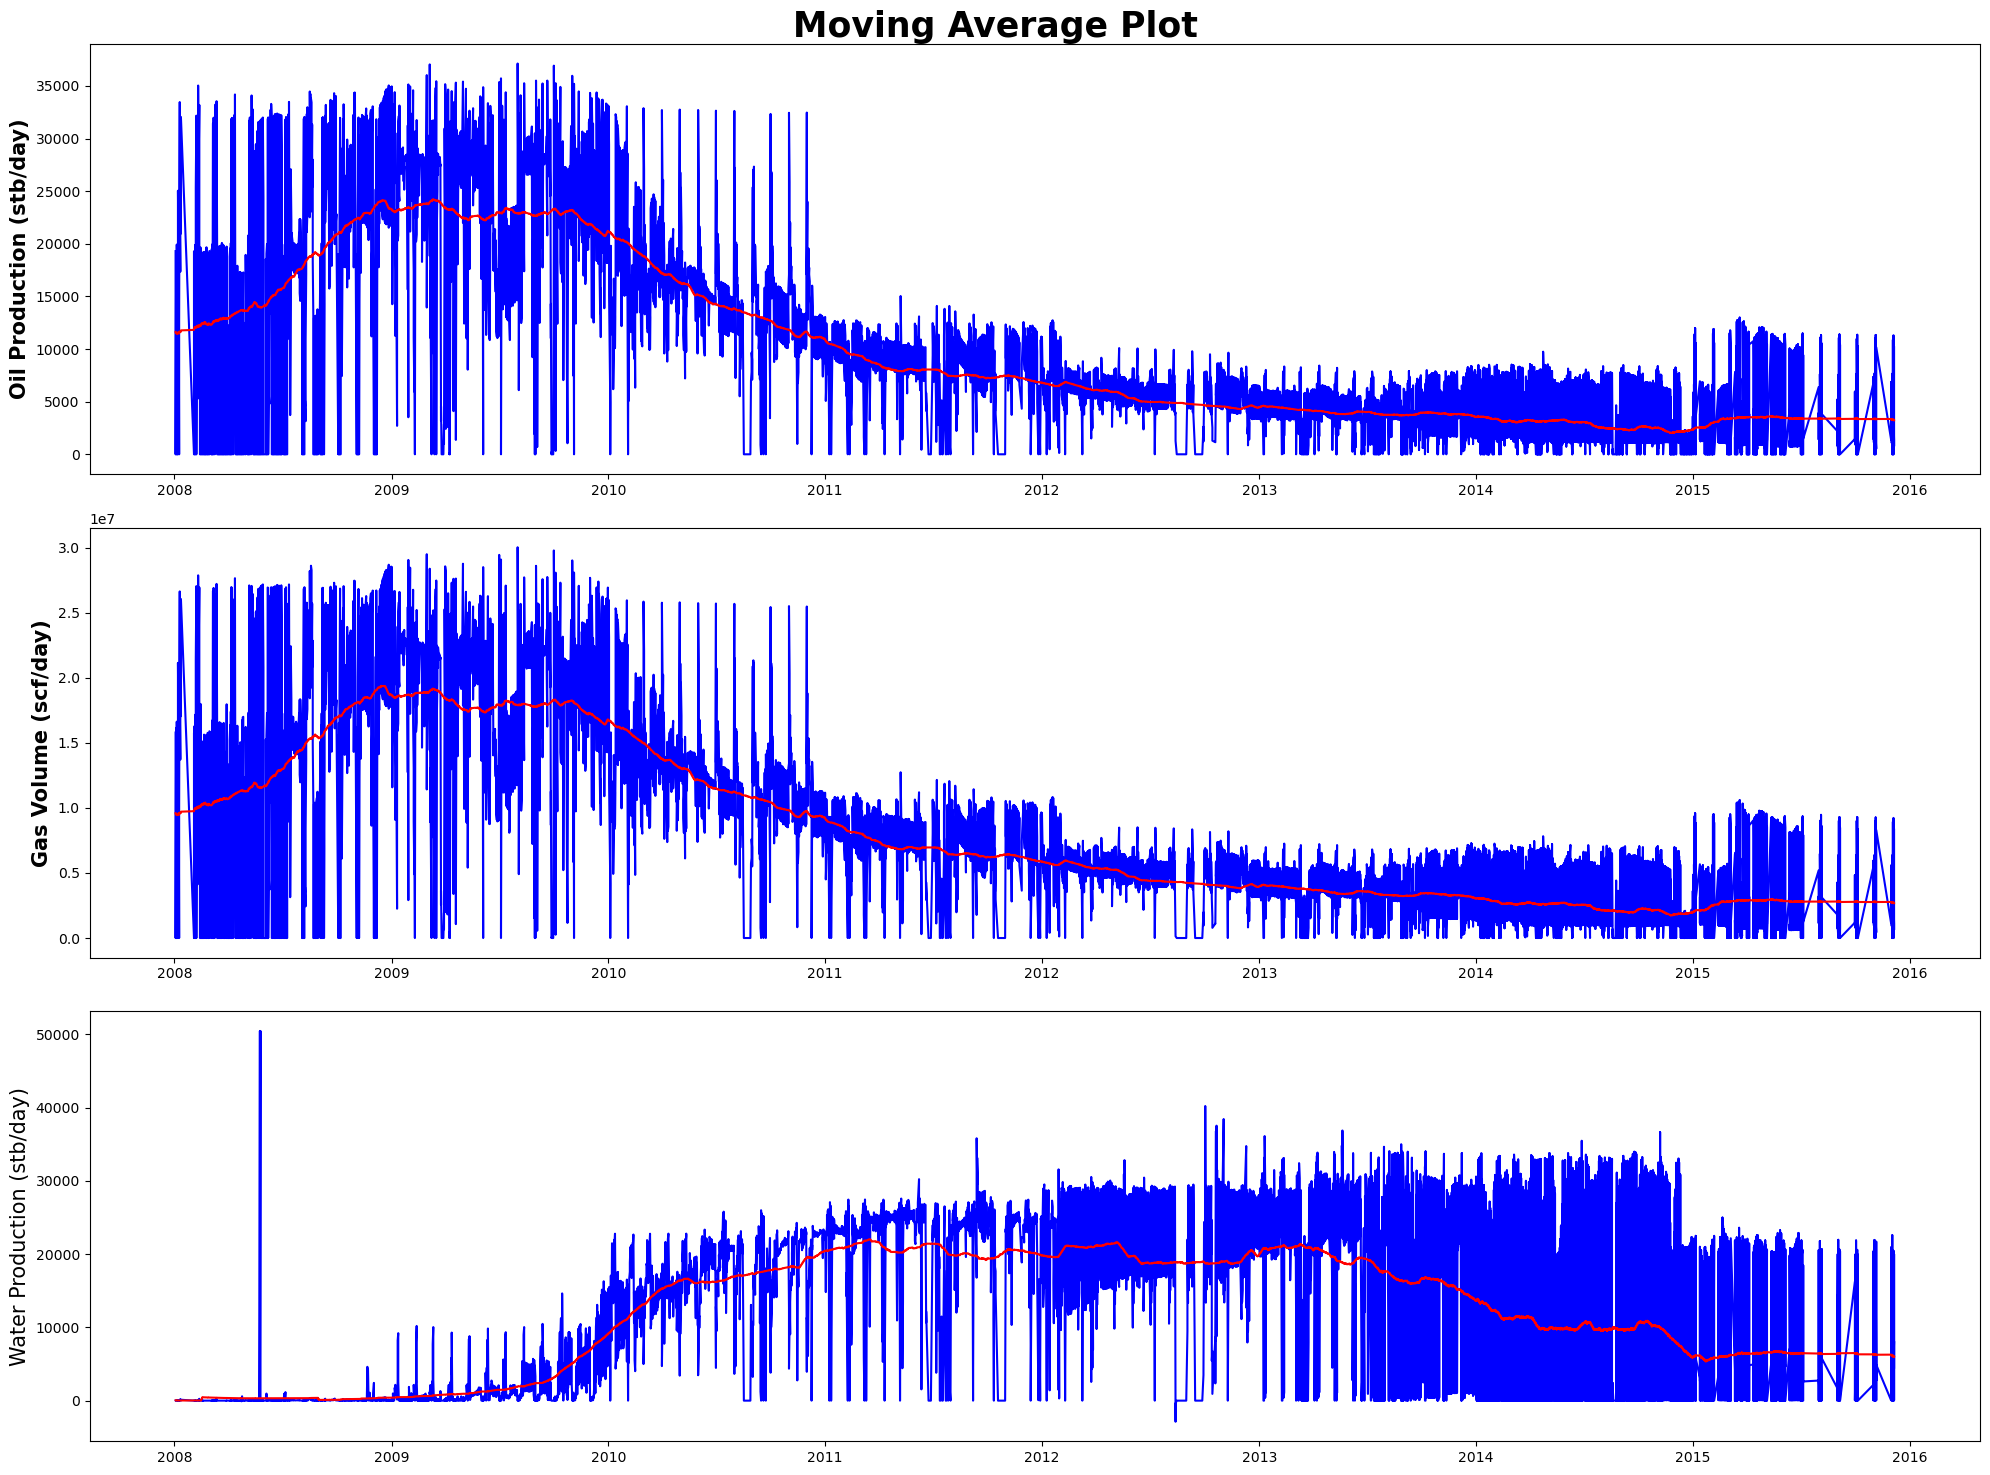

In [42]:
moving_average = train[features].rolling(window= 365, center = True, min_periods= 183).mean()
fig,axes = plt.subplots(nrows =3, ncols = 1,figsize=(20,15))

axes[0].plot(target_oil,color ="blue")#
axes[0].plot(moving_average["Oil Production (stb/day)"], color = "red", label="Oil Production")#
axes[0].set_ylabel("Oil Production (stb/day)", fontweight = "bold",fontsize = 15)


axes[1].plot(target_gas,color ="blue")
axes[1].plot(moving_average["Gas Volume (scf/day)"], color = "red")
axes[1].set_ylabel("Gas Volume (scf/day)", fontweight = "bold", fontsize = 15)

axes[2].plot(target_water,color ="blue")
axes[2].plot(moving_average["Water Production (stb/day)"], color = "red")
axes[2].set_ylabel("Water Production (stb/day)",  fontsize = 15)
plt.suptitle("Moving Average Plot", fontweight = "bold", fontsize = 25)
plt.tight_layout()
plt.show()

- <b><i>The moving average plot computed over a 365-day window shows the long-term trend for all three targets</i></b>

### Bivariate Analysis

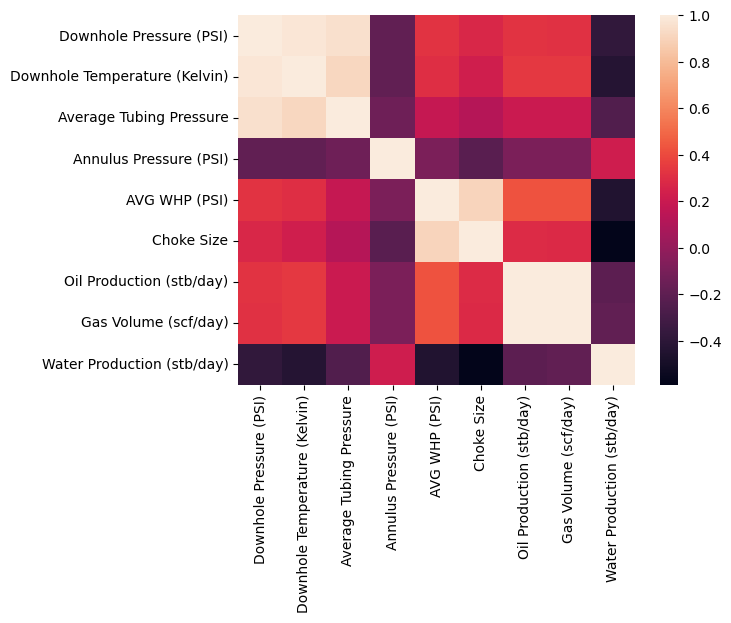

In [61]:
oil_df = train[features]#.drop(columns= ['Gas Volume (scf/day)','Water Production (stb/day)'])
oil_correl = oil_df.corr()
sns.heatmap(oil_correl)
plt.show()

## <b> Data Preprocessing </b>

In [95]:
drop_column=["Field Name","WELL_BORE_CODE","N_WELL_BORE_CODE","FLOW_KIND", "WELL_TYPE"]
def drop_columns(df):
    drop = df.drop(columns=drop_column)
    return drop
train = drop_columns(train)
test = drop_columns(test)
test = test.drop(columns =["Oil Production (stb/day)","Gas Volume (scf/day)","Water Production (stb/day)"])

In [97]:
# Encoding categorical features
cat_col = ["WellBore Name"]
def cat_encode(df):
    enc = pd.get_dummies(df, prefix = cat_col, columns = cat_col)
    return enc
train = cat_encode(train)
test = cat_encode(test)

## <b> Feature Engineering </b>

In [99]:
def create_features(df):
    """
   Engineering new features
    """
    df["day_of_week"]=df.index.day_of_week
    df["year"] = df.index.year
    df["yearly_quarter"]=df.index.quarter
    df["day_of_year"]=df.index.dayofyear
    df["month_of_year"]= df.index.month
    #Flow of fluid through a pipe is driven by pressure difference
    df["pressure_differential"] = df["Downhole Pressure (PSI)"] - df["AVG WHP (PSI)"]
    df["pressure_differential_annulus"] = df["Average Tubing Pressure"] - df["Annulus Pressure (PSI)"]
    df["P_T_ratio"] = df["Downhole Pressure (PSI)"]/df["Downhole Temperature (Kelvin)"]
    return df

train = create_features(df = train)
test = create_features(df = test)
train_oil =train.copy()
train_gas = train.copy()
train_water = train.copy()

## <b> Hyperparameter Tuning </b>

In [174]:
import optuna
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2024-08-11 15:35:11,522] A new study created in memory with name: no-name-d73303b0-55b8-4d7c-91f3-8134c27f71fe
[I 2024-08-11 15:35:14,507] Trial 0 finished with value: 4566.3024776335615 and parameters: {'learning_rate': 0.004784538164754025, 'depth': 6, 'subsample': 0.4684649231354046, 'colsample_bylevel': 0.38137287395618236, 'min_data_in_leaf': 44}. Best is trial 0 with value: 4566.3024776335615.
[I 2024-08-11 15:35:21,626] Trial 1 finished with value: 5235.857007783187 and parameters: {'learning_rate': 0.0012840139761849914, 'depth': 8, 'subsample': 0.964710991979809, 'colsample_bylevel': 0.7574819851714393, 'min_data_in_leaf': 16}. Best is trial 0 with value: 4566.3024776335615.
[I 2024-08-11 15:35:22,742] Trial 2 finished with value: 6363.814810203021 and parameters: {'learning_rate': 0.009574110156680074, 'depth': 2, 'subsample': 0.9402914255253524, 'colsample_bylevel': 0.24671088841404437, 'min_data_in_leaf': 23}. Best is trial 0 with value: 4566.3024776335615.
[I 2024-08-11

In [176]:
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

Best hyperparameters: {'learning_rate': 0.09441268835450686, 'depth': 5, 'subsample': 0.7625815136065095, 'colsample_bylevel': 0.9206702291298878, 'min_data_in_leaf': 42}
Best RMSE: 2449.5786975955307


## <b> Model Training and Evaluation - Oil</b>

In [101]:
target_cols = ["Oil Production (stb/day)", "Gas Volume (scf/day)","Water Production (stb/day)"]
x = train_oil.drop(columns=target_cols)
y = target_oil
x_train, x_, y_train, y_ = train_test_split(x,y,test_size=0.1,shuffle = False)
x_test,x_eval, y_test,y_eval= train_test_split(x_,y_, test_size=0.5, shuffle = False)

In [103]:
train_pool=Pool(x_train, y_train)
eval_pool=Pool(x_eval, y_eval)
params_oil = {"learning_rate": 0.07620096802885785, "depth": 5, "subsample": 0.8839467123874787, "colsample_bylevel": 0.8219375583352658, "min_data_in_leaf": 58}
catboost_model_oil = CatBoostRegressor(loss_function="RMSE",**params_oil)
catboost_model_oil.fit(train_pool, eval_set=eval_pool,verbose=100)

0:	learn: 8620.7043185	test: 6178.4107598	best: 6178.4107598 (0)	total: 2.55ms	remaining: 2.55s
100:	learn: 2210.2978306	test: 2310.2433869	best: 2310.2433869 (100)	total: 253ms	remaining: 2.25s
200:	learn: 1876.2455677	test: 2017.4358501	best: 2016.9755745 (199)	total: 488ms	remaining: 1.94s
300:	learn: 1688.4044663	test: 1814.9031843	best: 1811.5248767 (296)	total: 730ms	remaining: 1.7s
400:	learn: 1543.3783999	test: 1736.1158036	best: 1727.7497550 (374)	total: 969ms	remaining: 1.45s
500:	learn: 1423.7623765	test: 1708.8998959	best: 1691.7050880 (426)	total: 1.21s	remaining: 1.2s
600:	learn: 1332.8680977	test: 1686.5801117	best: 1677.2180663 (575)	total: 1.46s	remaining: 971ms
700:	learn: 1247.1868505	test: 1648.1745516	best: 1648.1745516 (700)	total: 1.76s	remaining: 750ms
800:	learn: 1184.4134585	test: 1619.0249698	best: 1616.8208664 (793)	total: 2.01s	remaining: 499ms
900:	learn: 1129.2263005	test: 1606.2696062	best: 1606.2696062 (900)	total: 2.25s	remaining: 247ms
999:	learn: 107

In [106]:
# K-fold Cross Validation
k_fold = KFold(n_splits=10,  shuffle=False)#5
oil_cv_score = cross_val_score(estimator=catboost_model_oil,
                                    X=x_train ,
                                    y=y_train,
                                    cv=k_fold,
                                    scoring="neg_mean_squared_error")
cv_scores = np.sqrt(oil_cv_score * (-1))

0:	learn: 7838.1959574	total: 2.57ms	remaining: 2.57s
1:	learn: 7368.0257149	total: 5.05ms	remaining: 2.52s
2:	learn: 6947.8846143	total: 7.77ms	remaining: 2.58s
3:	learn: 6573.0284466	total: 9.93ms	remaining: 2.47s
4:	learn: 6224.5526994	total: 12.6ms	remaining: 2.51s
5:	learn: 5887.8748657	total: 15.3ms	remaining: 2.53s
6:	learn: 5576.1671350	total: 19ms	remaining: 2.69s
7:	learn: 5301.7123989	total: 21.5ms	remaining: 2.67s
8:	learn: 5047.9773005	total: 24.3ms	remaining: 2.67s
9:	learn: 4817.1055684	total: 26.6ms	remaining: 2.63s
10:	learn: 4588.7497555	total: 29.9ms	remaining: 2.68s
11:	learn: 4398.6219112	total: 32.1ms	remaining: 2.65s
12:	learn: 4211.0946046	total: 34.6ms	remaining: 2.62s
13:	learn: 4044.2835150	total: 36.5ms	remaining: 2.57s
14:	learn: 3895.5392912	total: 39.3ms	remaining: 2.58s
15:	learn: 3753.5351285	total: 41.7ms	remaining: 2.56s
16:	learn: 3636.5007422	total: 44.1ms	remaining: 2.55s
17:	learn: 3524.7526851	total: 46.3ms	remaining: 2.52s
18:	learn: 3408.069042

In [108]:
train_score = mean_squared_error(y_train,catboost_model_oil.predict(x_train), squared=False)
print(f"Training Error: {round(train_score, 3)}")
score = mean_squared_error(y_test,catboost_model_oil.predict(x_test), squared=False)
print(f"Validation Error: {round(score,3)}")
print("Mean Generalization Error: ",round(cv_scores.mean(),3)) 


Training Error: 1088.831
Validation Error: 1491.241
Mean Generalization Error:  2385.26


## <b> Model Training and Evaluation - Gas</b>

In [118]:
target_cols = ["Oil Production (stb/day)", "Gas Volume (scf/day)","Water Production (stb/day)"]
train_gas = train_gas.drop(columns=target_cols)
scaler = MinMaxScaler() 
x = scaler.fit_transform(train_gas)
train_gas= pd.DataFrame(data = x, columns =train_gas.columns)

In [120]:
x = train_gas
y = target_gas
x_train, x_, y_train, y_ = train_test_split(x,y,test_size=0.1,shuffle = False)
x_test,x_eval, y_test,y_eval= train_test_split(x_,y_, test_size=0.5,shuffle = False)

In [122]:
train_pool=Pool(x_train, y_train)
eval_pool=Pool(x_eval, y_eval)
catboost_model_gas = CatBoostRegressor(loss_function="RMSE")
catboost_model_gas.fit(train_pool, eval_set=eval_pool,verbose=100)

Learning rate set to 0.067866
0:	learn: 6886449.3493319	test: 5109143.4152237	best: 5109143.4152237 (0)	total: 3.86ms	remaining: 3.85s
100:	learn: 1707054.8837340	test: 1820098.3328456	best: 1814521.7960325 (95)	total: 313ms	remaining: 2.79s
200:	learn: 1437406.9464986	test: 1557917.7764187	best: 1555895.6147040 (195)	total: 606ms	remaining: 2.41s
300:	learn: 1287237.2802742	test: 1475450.8601584	best: 1467574.3163767 (288)	total: 892ms	remaining: 2.07s
400:	learn: 1170285.0971131	test: 1453563.2606966	best: 1443383.5770798 (350)	total: 1.19s	remaining: 1.77s
500:	learn: 1074003.7714997	test: 1425492.9636424	best: 1425084.1609474 (498)	total: 1.5s	remaining: 1.5s
600:	learn: 993839.6308619	test: 1375662.3416455	best: 1375371.3508354 (599)	total: 1.82s	remaining: 1.21s
700:	learn: 925936.7238865	test: 1380106.4164042	best: 1370934.4786195 (645)	total: 2.14s	remaining: 913ms
800:	learn: 870955.0825955	test: 1377831.8113707	best: 1370330.2994476 (713)	total: 2.43s	remaining: 604ms
900:	le

In [126]:
# K-fold Cross Validation
k_fold = KFold(n_splits=10,  shuffle=False)
oil_cv_score = cross_val_score(estimator=catboost_model_gas,
                                    X=x_train ,
                                    y=y_train,
                                    cv=k_fold,
                                    scoring="neg_mean_squared_error")
cv_scores = np.sqrt(oil_cv_score * (-1))

Learning rate set to 0.053764
0:	learn: 6284469.2586362	total: 3.31ms	remaining: 3.3s
1:	learn: 6024240.9379172	total: 6.25ms	remaining: 3.12s
2:	learn: 5775199.3934201	total: 48ms	remaining: 15.9s
3:	learn: 5536463.4618882	total: 51.1ms	remaining: 12.7s
4:	learn: 5317558.2592824	total: 54.2ms	remaining: 10.8s
5:	learn: 5105327.9357705	total: 57.8ms	remaining: 9.57s
6:	learn: 4905894.5222110	total: 63.1ms	remaining: 8.95s
7:	learn: 4718532.3340699	total: 66.6ms	remaining: 8.26s
8:	learn: 4538963.1861281	total: 69.5ms	remaining: 7.66s
9:	learn: 4378131.6079421	total: 72.5ms	remaining: 7.18s
10:	learn: 4227363.9386386	total: 75.7ms	remaining: 6.81s
11:	learn: 4082226.0135317	total: 78.7ms	remaining: 6.48s
12:	learn: 3938904.1854871	total: 81.7ms	remaining: 6.2s
13:	learn: 3798084.8102658	total: 84.4ms	remaining: 5.95s
14:	learn: 3673788.7557312	total: 87.2ms	remaining: 5.73s
15:	learn: 3560665.8427879	total: 90ms	remaining: 5.54s
16:	learn: 3445206.0206658	total: 92.9ms	remaining: 5.37s


In [128]:

train_score = mean_squared_error(y_train,catboost_model_gas.predict(x_train), squared=False)
train_score ="{:,}".format(train_score)
print(f"Training Error: {train_score}")
score = mean_squared_error(y_test,catboost_model_gas.predict(x_test), squared=False)
score = "{:,}".format(score)
print(f"Validation Error: {score}")
cv_score = "{:,}".format(cv_scores.mean())
print("Mean Generalization Error: ", cv_score) 

Training Error: 784,891.8941774009
Validation Error: 1,212,970.008577026
Mean Generalization Error:  1,994,040.5222416047


## <b> Model Training and Evaluation - Water</b>

In [133]:
target_cols = ["Oil Production (stb/day)", "Gas Volume (scf/day)","Water Production (stb/day)"]
train_water = train_water.drop(columns=target_cols)

In [135]:
x = train_water
y = target_water
x_train, x_, y_train, y_ = train_test_split(x,y,test_size=0.1,shuffle = False)
x_test,x_eval, y_test,y_eval= train_test_split(x_,y_, test_size=0.5,shuffle = False)

In [137]:
train_pool=Pool(x_train, y_train)
eval_pool=Pool(x_eval, y_eval)
catboost_model_water = CatBoostRegressor(loss_function="RMSE")
catboost_model_water.fit(train_pool, eval_set=eval_pool,verbose=100)

Learning rate set to 0.067866
0:	learn: 11036.1036888	test: 8918.1672372	best: 8918.1672372 (0)	total: 3.64ms	remaining: 3.64s
100:	learn: 2744.4096535	test: 5049.8231878	best: 5035.8190715 (96)	total: 315ms	remaining: 2.8s
200:	learn: 2389.8718198	test: 4490.9386880	best: 4489.5832950 (199)	total: 609ms	remaining: 2.42s
300:	learn: 2159.6621674	test: 4447.5921714	best: 4425.9782875 (276)	total: 905ms	remaining: 2.1s
400:	learn: 1975.8710522	test: 4438.2453348	best: 4419.0261322 (363)	total: 1.22s	remaining: 1.82s
500:	learn: 1814.2660578	test: 4437.4294363	best: 4407.9276434 (488)	total: 1.52s	remaining: 1.51s
600:	learn: 1694.6544858	test: 4427.1716991	best: 4395.5945668 (557)	total: 1.81s	remaining: 1.2s
700:	learn: 1601.2166338	test: 4371.3915578	best: 4371.3915578 (700)	total: 2.1s	remaining: 898ms
800:	learn: 1513.1473793	test: 4402.5369271	best: 4369.6840424 (705)	total: 2.39s	remaining: 594ms
900:	learn: 1430.5600215	test: 4365.5851664	best: 4363.5658985 (892)	total: 2.68s	rema

In [140]:
# K-fold Cross Validation
k_fold = KFold(n_splits=10,  shuffle=False)
oil_cv_score = cross_val_score(estimator=catboost_model_water,
                                    X=x_train ,
                                    y=y_train,
                                    cv=k_fold,
                                    scoring='neg_mean_squared_error')
cv_scores = np.sqrt(oil_cv_score * (-1))

Learning rate set to 0.053764
0:	learn: 11060.2609517	total: 3.45ms	remaining: 3.45s
1:	learn: 10573.4683089	total: 6.62ms	remaining: 3.3s
2:	learn: 10150.6230786	total: 9.62ms	remaining: 3.2s
3:	learn: 9725.2691256	total: 12.6ms	remaining: 3.13s
4:	learn: 9318.9804743	total: 16.3ms	remaining: 3.25s
5:	learn: 8948.9047341	total: 19.6ms	remaining: 3.25s
6:	learn: 8599.3489312	total: 22.7ms	remaining: 3.22s
7:	learn: 8258.8586308	total: 25.6ms	remaining: 3.17s
8:	learn: 7942.2469115	total: 28.3ms	remaining: 3.11s
9:	learn: 7646.8824585	total: 31.7ms	remaining: 3.14s
10:	learn: 7358.6845854	total: 34.8ms	remaining: 3.13s
11:	learn: 7096.1789039	total: 38.1ms	remaining: 3.13s
12:	learn: 6844.2620573	total: 41.2ms	remaining: 3.12s
13:	learn: 6605.1771571	total: 44ms	remaining: 3.1s
14:	learn: 6392.6690868	total: 47.3ms	remaining: 3.11s
15:	learn: 6183.9706037	total: 50.2ms	remaining: 3.09s
16:	learn: 5975.6870951	total: 53.1ms	remaining: 3.07s
17:	learn: 5787.1009507	total: 55.9ms	remaining

In [142]:
train_score = mean_squared_error(y_train,catboost_model_water.predict(x_train), squared=False)
train_score ="{:,}".format(train_score)
print(f"Training Error: {train_score}")
score = mean_squared_error(y_test,catboost_model_water.predict(x_test), squared=False)
score = "{:,}".format(score)
print(f"Validation Error: {score}")
print("Mean Generalization Error: ",round(cv_scores.mean(),3)) 

Training Error: 1,395.3607845977306
Validation Error: 2,540.121344980188
Mean Generalization Error:  3293.45


##  <b>Feature Importance for Oil Production</b>

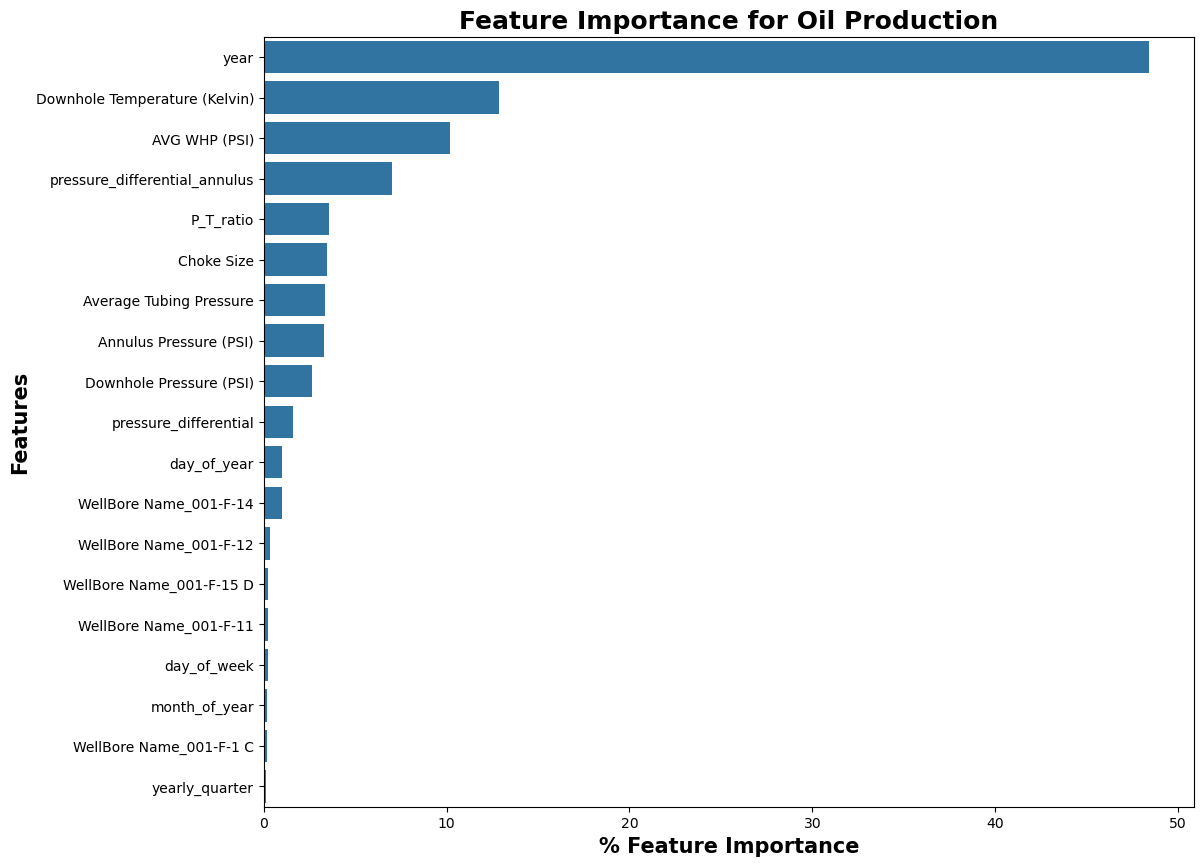

In [159]:
# Getting feature importances from the best trained model
feature_importances = catboost_model_oil.feature_importances_
# Creating a pandas DataFrame to store the feature importances along with the feature names
importance_df = pd.DataFrame({"Feature": x_train.columns, "Importance": feature_importances})
# Sorting the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)
importance_df["% Importance"] = importance_df["Importance"]* 100
# Creating the plot
plt.figure(figsize=(12, 10))
sns.barplot(data = importance_df,x="Importance", y="Feature",orient="h")
plt.xlabel("% Feature Importance",fontsize=15,fontweight ="bold")
plt.ylabel("Features",fontsize=15,fontweight ="bold")
plt.title("Feature Importance for Oil Production",fontsize=18, fontweight ="bold" )
plt.show()


## Feature Importance for Gas Production

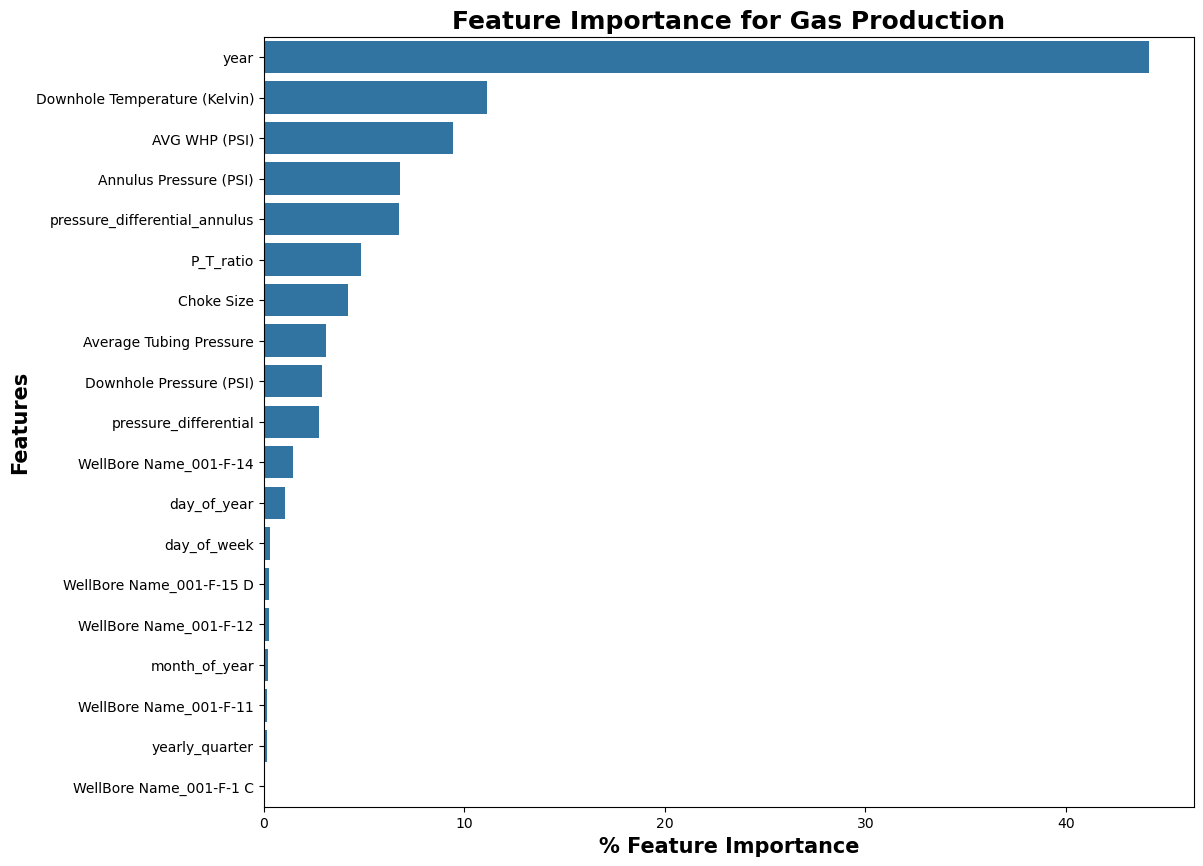

In [161]:
# Getting feature importances from the best trained model
feature_importances = catboost_model_gas.feature_importances_
# Creating a pandas DataFrame to store the feature importances along with the feature names
importance_df = pd.DataFrame({"Feature": x_train.columns, "Importance": feature_importances})
# Sorting the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)
importance_df["% Importance"] = importance_df["Importance"]* 100
# Creating the plot
plt.figure(figsize=(12, 10))
sns.barplot(data = importance_df,x="Importance", y="Feature",orient="h")
plt.xlabel("% Feature Importance",fontsize=15,fontweight ="bold")
plt.ylabel("Features",fontsize=15,fontweight ="bold")
plt.title("Feature Importance for Gas Production",fontsize=18, fontweight ="bold" )
plt.show()


## Feature Importance for Water Production

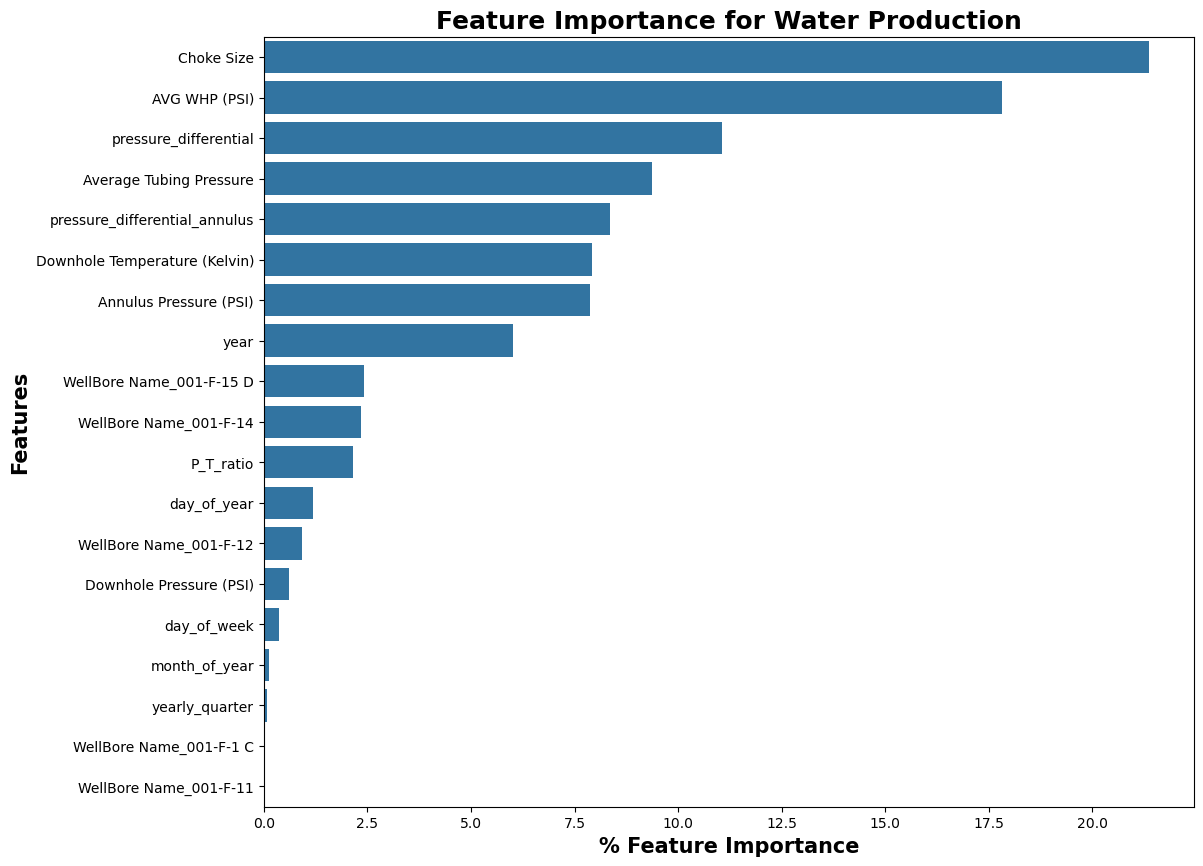

In [163]:
# Getting feature importances from the best trained model
feature_importances = catboost_model_water.feature_importances_
# Creating a pandas DataFrame to store the feature importances along with the feature names
importance_df = pd.DataFrame({"Feature": x_train.columns, "Importance": feature_importances})
# Sorting the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)
importance_df["% Importance"] = importance_df["Importance"]* 100
# Creating the plot
plt.figure(figsize=(12, 10))
sns.barplot(data = importance_df,x="Importance", y="Feature",orient="h")
plt.xlabel("% Feature Importance",fontsize=15,fontweight ="bold")
plt.ylabel("Features",fontsize=15,fontweight ="bold")
plt.title("Feature Importance for Water Production",fontsize=18, fontweight ="bold" )
#plt.savefig("oil_feature.jpg", format="jpeg", quality=95,dpi = 300)
plt.show()


## Saving Trained Models

In [116]:
import pickle
pickle_doc = open("model_oil.pkl", "wb") 
pickle.dump(catboost_model_oil, pickle_doc)
pickle_doc.close()

In [131]:
import pickle
pickle_doc2 = open("model_gas.pkl", 'wb')
pickle.dump(catboost_model_gas, pickle_doc2)
pickle_doc2.close()

pickle_scale = open("scaler_gas.pkl", 'wb')
pickle.dump(scaler,pickle_scale)
pickle_scale.close()

In [147]:

pickle_doc3 = open('model_water.pkl', 'wb')
pickle.dump(catboost_model_water, pickle_doc3)
pickle_doc3.close()